In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import random
from zipfile import ZipFile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset
from langdetect import detect, DetectorFactory
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from collections import Counter
import nltk
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set random seeds for reproducible and consistent results
set_seed(42)



/home/tom/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Amazon_Fashion", trust_remote_code=True)
print(dataset["full"][0])

# Overview
reviews = dataset['full'].to_pandas()


# Check the first 5 observations
print('----------------------------------------\nThe first 5 observations of the dataset:\n----------------------------------------')
display(reviews.head())

# Check the number of observations and features
print('--------------------------\nDimensions of the dataset:\n--------------------------\n')
print('Observations: ' + str(reviews.shape[0]))
print('Variables: ' + str(reviews.shape[1]))
print('Unique Products: ' + str(len(reviews['asin'].unique())))
print('Non-verified purchases: ' + str(len(reviews[reviews['verified_purchase'] == False])))

#
print('\n--------------------------\nMissing data distribution:\n--------------------------\n')
print(reviews.isna().sum())


KeyboardInterrupt: 

In [97]:
# Check for bot_like behavior
reviews['datetime'] = pd.to_datetime(reviews['timestamp'], unit='ms')
reviews['date'] = reviews['datetime'].dt.strftime('%Y-%m-%d')

# Group_by to identify how manny reviews users make per day
review_counts = reviews[['user_id', 'date','text']].groupby(['user_id', 'date']).count()
review_counts.reset_index(inplace=True)
review_counts.rename(columns={'text': 'count'}, inplace=True)
review_counts.sort_values('count', ascending=False, inplace=True)
review_counts.head(10)

,user_id,date,count
339362,AEM5PO3PITEPDNNATSGM2PD6C62Q,2018-06-29,18
1030514,AFR2XB7TRMQJCRB6INYP2W73EH5A,2021-06-08,16
305453,AEKEF7PBXCP345X2UPV3IJY6QMNQ,2017-01-06,13
1022576,AFQNKOJVCTSPUXQIHHKIZHUC4U2Q,2014-12-04,13
2004685,AHF7II6UR3KZ7456G4LVM5K4JVQQ,2019-01-04,13
896044,AFJWIAJZOMSJFKQQDMOXUEJZKDVQ,2018-07-10,12
1582198,AGON3GV6Q37EUUSTQUWEAZ35D5JA,2017-04-15,12
1148317,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,2020-11-29,11
443634,AERPMJNZRD76NEI6NJBPRXKKEPMQ,2022-05-16,11
2289655,AHUEULPD67THST4AIUTZFI7GQAEQ,2017-11-17,10


In [98]:
for i in range(0,20,1):
    unique_users= len(review_counts[review_counts['count']>i]['user_id'].unique())
    print(f'{unique_users} users have posted more than {i} reviews on at least one day')

2035490 users have posted more than 0 reviews on at least one day
83488 users have posted more than 1 reviews on at least one day
10351 users have posted more than 2 reviews on at least one day
2907 users have posted more than 3 reviews on at least one day
872 users have posted more than 4 reviews on at least one day
379 users have posted more than 5 reviews on at least one day
148 users have posted more than 6 reviews on at least one day
71 users have posted more than 7 reviews on at least one day
26 users have posted more than 8 reviews on at least one day
15 users have posted more than 9 reviews on at least one day
9 users have posted more than 10 reviews on at least one day
7 users have posted more than 11 reviews on at least one day
5 users have posted more than 12 reviews on at least one day
2 users have posted more than 13 reviews on at least one day
2 users have posted more than 14 reviews on at least one day
2 users have posted more than 15 reviews on at least one day
1 users 

In [99]:
# Set threshhold for bot_behavior to 3 or more reviews on one day
threshold = 3
bot_users = review_counts[review_counts['count']>=threshold]
bot_users_id_list = bot_users['user_id'].unique().tolist()
bot_users_id_list

['AEM5PO3PITEPDNNATSGM2PD6C62Q',
 'AFR2XB7TRMQJCRB6INYP2W73EH5A',
 'AEKEF7PBXCP345X2UPV3IJY6QMNQ',
 'AFQNKOJVCTSPUXQIHHKIZHUC4U2Q',
 'AHF7II6UR3KZ7456G4LVM5K4JVQQ',
 'AFJWIAJZOMSJFKQQDMOXUEJZKDVQ',
 'AGON3GV6Q37EUUSTQUWEAZ35D5JA',
 'AFXF3EGQTQDXMRLDWFU7UBFQZB7Q',
 'AERPMJNZRD76NEI6NJBPRXKKEPMQ',
 'AHUEULPD67THST4AIUTZFI7GQAEQ',
 'AGWSCUQ6FPLVB4JD457YOQO6BBVA',
 'AFCXBV3VMX2TP5V4RBPM744BBZAA',
 'AGMLJDY5MWQUGPBA3LIROCYR743Q',
 'AE5XME5D6REQUOXUCWIR7NIO7QAA',
 'AEMT4Q3OEWSJWLOWNPGL6JLI7IIA',
 'AH4OAL6YYB3HSA25HAEXWBT5255Q',
 'AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1',
 'AEG2MF2H6736V3XILN72GC4FHNHQ',
 'AFAFTYAKD3AZERQRT46PWZ4P2ZPA',
 'AFRKEXHAJU3CWRNGZZ3BB7QKDWDA',
 'AGCQLCCUKY3DD2AIOACFB2GQO6BA',
 'AFDAS2HEWPIDGEUBCRWWHCGRYE4Q',
 'AHL3SPQAC6ZUEHEVS3HBDAK5QK5Q',
 'AGP6XV24ZFWNMOXGBYNPUDTXPNQA',
 'AE22JJNSDFUJU4JXP6NRFBPOSWWA',
 'AHVBC24ZPT5YC5C2ASTQTBCZ5FWA',
 'AF6RFA6T3KGL2PMIAEML5F2HINGQ',
 'AEF5TOMSLTYO5TPZ2RA5JYQOSPSA',
 'AHEHDITUC2UE5DWYN7WFQISC3UZA',
 'AGYWMOABBXZQ73ELMG6FD3HZ3XPQ',
 'AGIQ6I

#### Apply first filters

In [100]:
raw_number_of_reviews = len(reviews)
print('Number of reviews before initial preprocessing: ' + str(raw_number_of_reviews))

# Remove rows with empty text string
reviews = reviews[reviews['text'] != '']
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove duplicates
reviews = reviews.drop_duplicates(subset=['asin', 'text'], keep='first').reset_index(drop=True)
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove non-verified purchases
reviews = reviews[reviews['verified_purchase'] == True]
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

# Remove bot like users
reviews = reviews[~reviews['user_id'].isin(bot_users_id_list)]
diff = raw_number_of_reviews - len(reviews)
print(f'Removed {diff} rows')

print('Number of reviews after initial preprocessing: ' + str(len(reviews)))

Number of reviews before initial preprocessing: 2500939
Removed 692 rows
Removed 28878 rows
Removed 190148 rows
Removed 228614 rows
Number of reviews after initial preprocessing: 2272325


Next steps:
- remove non-english reviews
- classify reviews by their saentiment
- generate a balanced dataset (sentiments) that is used for model training

## Detect language

In [101]:
# Setting a consistent seed
DetectorFactory.seed = 12345

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown/not recognizable'

# Apply the function to detect language
reviews['language'] = reviews['text'].apply(detect_language)

# Count the frequency of each language
language_counts = Counter(reviews['language'])
display(language_counts)


Counter({'en': 2094077,
         'ro': 28409,
         'es': 25603,
         'af': 14973,
         'so': 13116,
         'ca': 9791,
         'fr': 9372,
         'sl': 8827,
         'no': 7836,
         'de': 6655,
         'et': 5440,
         'da': 4919,
         'it': 4729,
         'unknown/not recognizable': 4473,
         'pl': 4368,
         'tl': 3745,
         'nl': 3461,
         'pt': 3193,
         'sq': 2678,
         'cy': 2647,
         'cs': 2580,
         'sv': 1956,
         'vi': 1685,
         'sk': 1498,
         'hu': 1329,
         'id': 1300,
         'fi': 1281,
         'tr': 738,
         'sw': 618,
         'hr': 616,
         'lv': 249,
         'lt': 158,
         'bg': 2,
         'he': 1,
         'ko': 1,
         'zh-cn': 1})

In [102]:
# Remove non-english reviews
reviews_noeng = reviews[reviews['language'] == 'en']
diff = len(reviews) - len(reviews_noeng)
print(f'Removed {diff} rows')


Removed 178248 rows


#### Save intermediate results 1
--> checkpoint1

In [103]:
reviews_noeng.to_csv('checkpoint1.csv', index=False)

In [ ]:
#Function to check if the review contains any irrelevant keywords
# def contains_irrelevant_keywords(text):
#    keywords = ['shipping', 'delivery']
#    return any(keyword in text.lower() for keyword in keywords)

## Sentiment Analysis
--> script is run in kaggle environment

In [4]:
df  = pd.read_csv('checkpoint1.csv')
len(df)

2094077

In [ ]:
# Spli data in chunks to avoid runtime errors in kaggle
df  = pd.read_csv('checkpoint1.csv')
split = int(len(df)/2)
print(split)
df1 = df.iloc[:split]
df2 = df.iloc[split:]

In [ ]:
split = int(len(df1)/2)
print(split)
df11 = df1.iloc[:split]
df11.to_csv('data/senti_split11.csv')
df12 = df1.iloc[split:]
df11.to_csv('data/senti_split12.csv')

split = int(len(df2)/2)
print(split)
df21 = df2.iloc[:split]
df21.to_csv('data/senti_split21.csv')
df22 = df2.iloc[split:]
df22.to_csv('data/senti_split22.csv')


In [2]:
checkpoint = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/home/tom/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # Import tqdm

import numpy as np 
import pandas as pd 
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from collections import Counter


# Set random seeds for reproducible and consistent results
set_seed(42)


df = pd.read_csv('/kaggle/input/checkpoint1/checkpoint1.csv')
checkpoint = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

class ScamDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        return inputs

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
model.eval()  # Set the model to evaluation mode

# Create a Dataset and DataLoader
texts = df['text'].copy()
dataset = ScamDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

predictions = []

with torch.no_grad():
    # Wrap the dataloader with tqdm to track progress
    for batch in tqdm(dataloader, desc="Classifying"):
        # Move batch data to GPU
        inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).tolist()
        predictions.extend(batch_predictions)

print("Classification complete.")



In [ ]:
# Add predictions to DataFrame
df['label'] = predictions
df

#### Save intermediate results 2
--> checkpoint2

In [7]:
sentiments = pd.DataFrame()

for split in [11,12,21,22]:

    with ZipFile(f'Data/senti_split_{split}.zip', 'r') as zip:
        with zip.open(f'senti_split_{split}.csv') as file:
            senti_split = pd.read_csv(file)
            sentiments = pd.concat([sentiments,senti_split])

sentiments.to_csv('checkpoint2.csv', index=False)
sentiments

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523515,5.0,Five Stars,Great quality. Sturdy and tight. Came on time....,[],B00YGFMQC0,B00YGFMQC0,AEEMZHE5K6EIQHLIGHCNYJTWDUIA,1474207318000,0,True,2016-09-18 14:01:58.000,2016-09-18,en,1
523516,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,1466799158000,0,True,2016-06-24 20:12:38.000,2016-06-24,en,1
523517,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1525799105585,0,True,2018-05-08 17:05:05.585,2018-05-08,en,0
523518,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1482013711000,0,True,2016-12-17 22:28:31.000,2016-12-17,en,0


In [8]:
# Split pos/neg 40/60 to avoid positivity bias in gpt2


df_pos = sentiments[sentiments['label'] == 1].sample(40000) # 1 = positive
df_neg = sentiments[sentiments['label'] == 0].sample(60000) # 0 = negative
df_sampled = pd.concat([df_pos, df_neg])
df_sampled.to_csv('checkpoint3.csv', index=False)

### Save HF dataset for GPT2-finetuning

In [14]:
with ZipFile('Data/checkpoint3.zip', 'r') as zip:
        with zip.open('checkpoint3.csv') as file:
                df = pd.read_csv(file)
                print(df['label'].value_counts()) # 1 = positive; # 0 = negative
                dataset = Dataset.from_pandas(df)



label
1    60000
0    40000
Name: count, dtype: int64


In [10]:
dataset = dataset.select_columns(['text'])
dataset

Dataset({
    features: ['text'],
    num_rows: 100000
})

In [11]:
dataset.save_to_disk('Data/trainset.hf')

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

## Descriptive statistics of all data

In [2]:
# Load original data not sampled
with ZipFile('Data/checkpoint2.zip', 'r') as zip:
        with zip.open('checkpoint2.csv') as file:
                reviews = pd.read_csv(file)

In [3]:
reviews['sentiment'] = reviews['label'].copy()
# Replace 1 with 'POS' and 0 with 'NEG'
reviews['sentiment'].replace({1: 'POS', 0: 'NEG'}, inplace=True)
print(reviews['sentiment'])

0          POS
1          POS
2          NEG
3          NEG
4          POS
          ... 
2094072    POS
2094073    POS
2094074    NEG
2094075    NEG
2094076    POS
Name: sentiment, Length: 2094077, dtype: object


In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/tom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

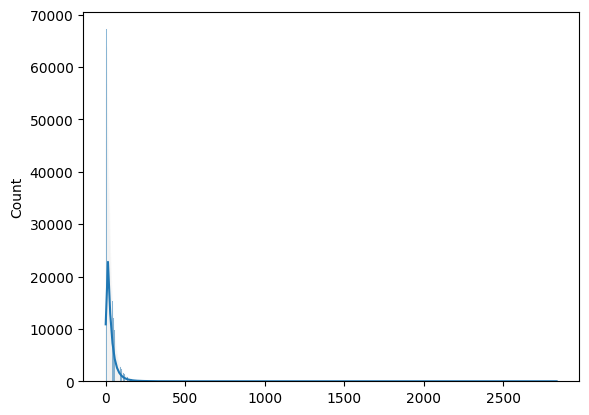

Number of reviews with more than 1024 tokens: 54
Number of reviews with more than 512 tokens: 688
Average number of tokens: 31.85128579321582


In [5]:
# Get a rough understanding of the tokens
revs = reviews['text'].copy()

doc_lengths = []

for rev in revs:
    tokens = nltk.word_tokenize(rev)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
[]
#
sns.histplot(doc_lengths, kde=True)
plt.show()

print('Number of reviews with more than 1024 tokens:', str(np.sum(doc_lengths > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(doc_lengths > 512)))
print('Average number of tokens:', str(np.average(doc_lengths)))

In [6]:
reviews['textLengths'] = doc_lengths

In [7]:
import re

# testing 
#reviews = reviews.sample(100)
PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" 

def clean_text(text):
    """Doc cleaning"""
    
    # Lowering text
    text = text.lower()
    
    # Removing punctuation
    text = "".join([c for c in text if c not in PUNCTUATION])
    
    # Removing whitespace and newlines
    text = re.sub('\s+',' ',text)
    
    return text

reviews['cleaned_text'] = reviews['text'].apply(clean_text)

In [8]:
# Split on whitespaces, remove puncutation, remove stopwords
def clean_text(df, text_column):
    stop_words = set(stopwords.words('english'))
    punctuation_table = str.maketrans('', '', string.punctuation)
    
    def process_text(text):
        # Split text by whitespace
        words = word_tokenize(text)
        # Remove punctuation and stopwords
        cleaned_words = [word.translate(punctuation_table).lower() for word in words if word.isalnum() and word.lower() not in stop_words]
        return cleaned_words
    
    df[text_column + 'SplitAndCleaned'] = df[text_column].apply(process_text)
    return df

# Clean the text
reviews_clean_tokens = clean_text(reviews, 'text')

# Determine the review length
reviews_clean_tokens['textLength'] = reviews_clean_tokens['textSplitAndCleaned'].apply(len)

# Check the DataFrame
display(reviews_clean_tokens)

# ...
print('Number of reviews with more than 1024 tokens:', str(np.sum(reviews_clean_tokens['textLength'] > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(reviews_clean_tokens['textLength'] > 512)))
print('Number of reviews with more than 150 tokens:', str(np.sum(reviews_clean_tokens['textLength'] > 150)))
print('Average number of tokens:', str(np.average(reviews_clean_tokens['textLength'])))

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label,sentiment,TextLengths,cleaned_text,textSplitAndCleaned,textLength
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1,POS,67,i think this locket is really pretty the insid...,"[think, locket, really, pretty, inside, back, ...",30
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1,POS,1,great,[great],1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0,NEG,20,one of the stones fell out within the first 2 ...,"[one, stones, fell, within, first, 2, weeks, w...",11
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0,NEG,21,crappy socks money wasted bought to wear with ...,"[crappy, socks, money, wasted, bought, wear, t...",10
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1,POS,64,i love these glasses they fit perfectly over m...,"[love, glasses, fit, perfectly, regular, recta...",27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094072,5.0,Five Stars,Great quality. Sturdy and tight. Came on time....,[],B00YGFMQC0,B00YGFMQC0,AEEMZHE5K6EIQHLIGHCNYJTWDUIA,1474207318000,0,True,2016-09-18 14:01:58.000,2016-09-18,en,1,POS,14,great quality sturdy and tight came on time gr...,"[great, quality, sturdy, tight, came, time, gr...",8
2094073,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,1466799158000,0,True,2016-06-24 20:12:38.000,2016-06-24,en,1,POS,31,the tie tacks were the size that allowed them ...,"[tie, tacks, size, allowed, used, add, militar...",16
2094074,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1525799105585,0,True,2018-05-08 17:05:05.585,2018-05-08,en,0,NEG,10,says ten tie clips but o only received 7,"[says, ten, tie, clips, received, 7]",6
2094075,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1482013711000,0,True,2016-12-17 22:28:31.000,2016-12-17,en,0,NEG,19,when i received them 23 of them did not open p...,"[received, open, properly, looks, though, brea...",7


Number of reviews with more than 1024 tokens: 0
Number of reviews with more than 512 tokens: 18
Number of reviews with more than 150 tokens: 1898
Average number of tokens: 13.44116095062407


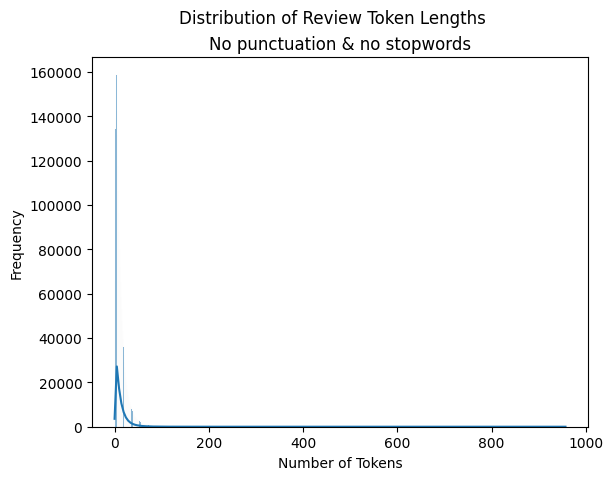

In [9]:
# Review length
sns.histplot(reviews_clean_tokens['textLength'], kde=True)
#sns.histplot(doc_lengths, kde=True)
plt.suptitle('Distribution of Review Token Lengths')
plt.title('No punctuation & no stopwords')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [10]:
sentiment_distribution = reviews_clean_tokens.groupby(['rating','sentiment']).size().reset_index(name='Count')
sentiment_distribution 

,rating,sentiment,Count
0,1.0,NEG,249857
1,1.0,POS,9903
2,2.0,NEG,135674
3,2.0,POS,15944
4,3.0,NEG,132765
5,3.0,POS,78640
6,4.0,NEG,42416
7,4.0,POS,251940
8,5.0,NEG,23329
9,5.0,POS,1153609


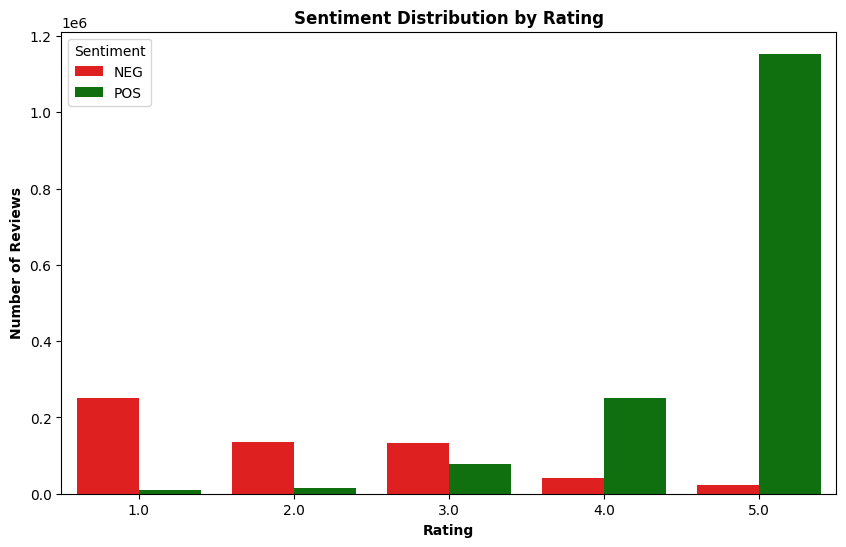

In [11]:
# Sentiment distributions
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Group by Review_Score and Sentiment
sentiment_distribution = reviews_clean_tokens.groupby(['rating', 'sentiment']).size().reset_index(name='Count')

# Plot bar graph using seaborn
sns.barplot(x='rating', y='Count', hue='sentiment', data=sentiment_distribution, palette=['red', 'green'])
# Set plot title and labels
plt.title('Sentiment Distribution by Rating', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')
plt.legend(title='Sentiment')

# Save the plot
plt.savefig('sentiment_dist_by_rating.pdf', dpi=1500)

# Show the plot
plt.show()

In [13]:
reviews_clean_tokens.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label,sentiment,TextLengths,cleaned_text,textSplitAndCleaned,textLength
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1,POS,67,i think this locket is really pretty the insid...,"[think, locket, really, pretty, inside, back, ...",30
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1,POS,1,great,[great],1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0,NEG,20,one of the stones fell out within the first 2 ...,"[one, stones, fell, within, first, 2, weeks, w...",11
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0,NEG,21,crappy socks money wasted bought to wear with ...,"[crappy, socks, money, wasted, bought, wear, t...",10
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1,POS,64,i love these glasses they fit perfectly over m...,"[love, glasses, fit, perfectly, regular, recta...",27


### WordClouds

In [12]:
reviews_clean_tokens_subset_sentiment_wordclouds = reviews_clean_tokens.copy()
reviews_clean_tokens_subset_sentiment_wordclouds['textSplitAndCleaned'] = reviews_clean_tokens_subset_sentiment_wordclouds['textSplitAndCleaned'].apply(lambda word_list: [word for word in word_list if word != 'br'])

# Combine the words into a single string
text = ' '.join([' '.join(review) for review in reviews_clean_tokens_subset_sentiment_wordclouds['TextSplitAndCleaned']])

# Wordcloud of common words
wordcloud = WordCloud(width=4000, height=2000, background_color ='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.pdf', format='pdf', dpi=1500)
plt.show()

KeyError: 'TextSplitAndCleaned'

In [ ]:
# Define a function to generate word cloud for a given rating
def generate_wordcloud_for_rating(df, rating):
    # Filter the DataFrame for the given rating
    filtered_df = df[df['Score'] == rating]
    # Combine the text from the 'Cleaned_Text' column into a single string
    text = ' '.join([' '.join(review) for review in filtered_df['textSplitAndCleaned']])
    # Generate the word cloud
    wordcloud = WordCloud(width=4000, height=2000, background_color='black').generate(text)
    return wordcloud

# Create a figure with subplots for each rating
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Generate and plot word clouds for each rating
for rating in range(1, 6):
    wordcloud = generate_wordcloud_for_rating(reviews_clean_tokens_subset_sentiment_wordclouds, rating)
    ax = axes[(rating-1) // 2, (rating-1) % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Rating {rating}', fontsize=16, weight='bold')
    ax.axis('off')

# Adjust layout and remove the empty subplot
plt.delaxes(axes[2][1])  # remove the empty subplot if there is any
plt.savefig('wordclouds_by_rating.pdf', format='pdf', dpi=1500)
plt.show()